In [90]:
import pandas as pd
import numpy as np
import requests
import os

import rdkit
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import PandasTools

from rdkit import RDConfig
from rdkit.Chem import rdRGroupDecomposition

from rdkit.Chem import AllChe
from rdkit.Chem import Draw

In [67]:
CIDS = pd.read_csv('chem_id_pubmed.txt', 
                   names = ['CID'])

In [68]:
CIDS = CIDS['CID'].apply(lambda x: int(x))

### Get data from Pubchem

In [36]:
pip install pubchempy

In [37]:
import pubchempy as pcp

In [70]:
chem_data = pd.DataFrame(columns = ['CID', 'CanonicalSMILES', 'Fingerprint2D', 'MolecularFormula'])

In [74]:
for CID in CIDS:
    comp = pcp.Compound.from_cid(CID)
    new_row = {'CID': comp.cid, 'CanonicalSMILES':comp.canonical_smiles, 'Fingerprint2D':comp.fingerprint, 'MolecularFormula':comp.molecular_formula}
    chem_data = chem_data.append(new_row, ignore_index=True)


In [76]:
chem_data.to_csv('chem_data.csv') 

### SMILES to RDKit Molecules, to SDF

In [80]:
# load csv file with smiles and fingerprints
chem_data = pd.read_csv('chem_data.csv')

In [81]:
# add column with rdkit molecule objects
PandasTools.AddMoleculeColumnToFrame(chem_data, 'CanonicalSMILES','Molecule')

In [ ]:
chem_data['Molecule']

In [9]:
# save to sdf
PandasTools.WriteSDF(chem_data, 'chem_data.sdf', molColName='Molecule', properties=list(chem_data.columns))

### Molecule Visualisation

In [107]:
ms = [] # список молекул

for mol in chem_data['Molecule']:
    ms.append(mol)  


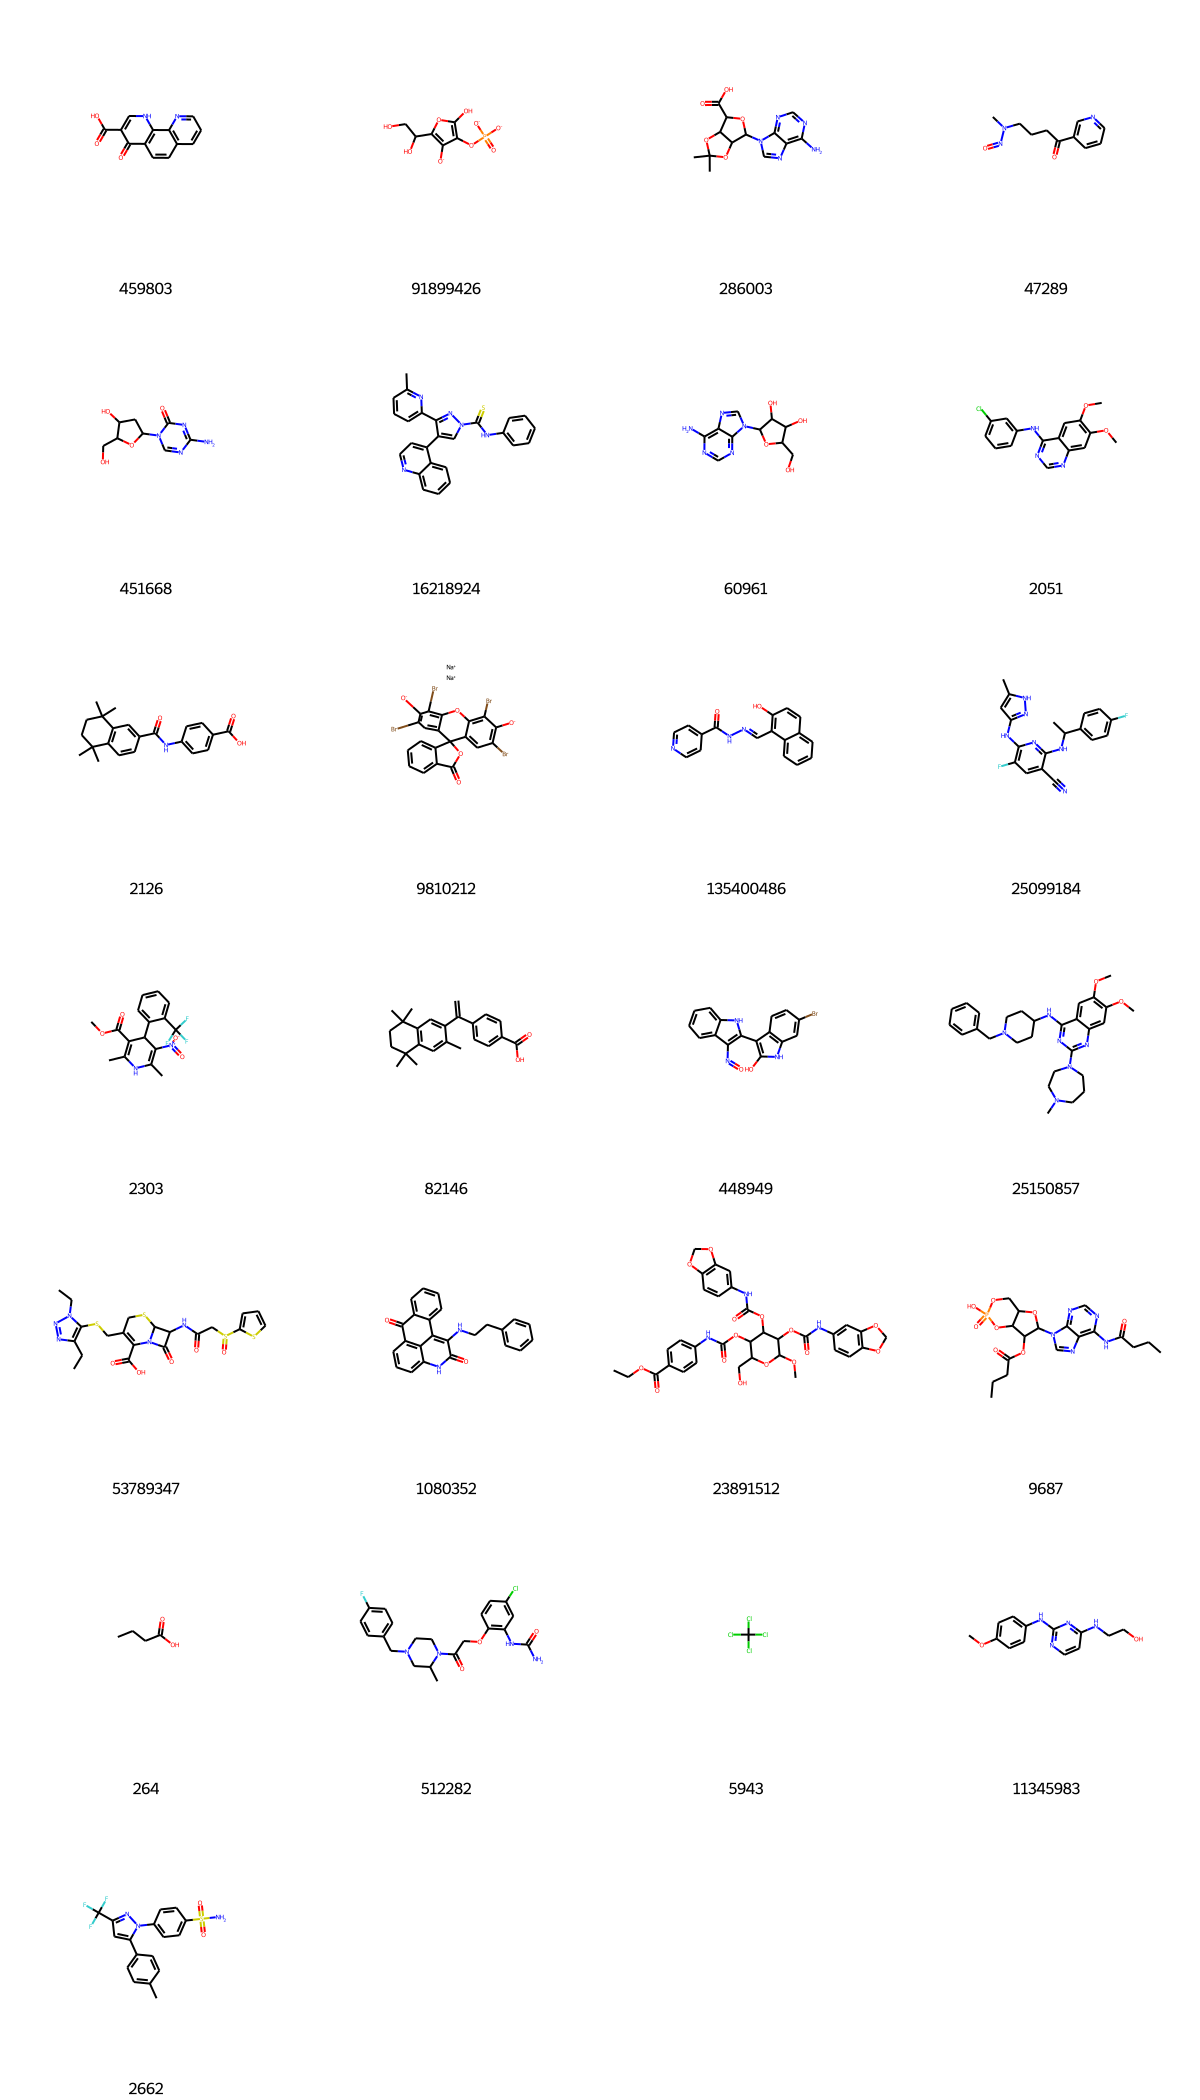

In [167]:
rdkit.Chem.PandasTools.FrameToGridImage(chem_data,
                                        column='Molecule', 
                                        legendsCol='CID',
                                        molsPerRow=4,subImgSize=(300,300))

### Get Fingerprints

#### Morgan fingerprints

In [110]:
from rdkit import DataStructs

In [115]:
chem_data['Morgan'] = chem_data['Molecule'].apply(lambda x:
                                                  AllChem.GetMorganFingerprint(x,2))

In [161]:
morgan_Similarity = []

for fp1 in chem_data['Morgan']:
    for fp2 in chem_data['Morgan']:
        morgan_Similarity.append(DataStructs.DiceSimilarity(fp1,fp2))                     


 #### MACCS keys

In [128]:
from rdkit.Chem import MACCSkeys

In [129]:
chem_data['MACCS keys'] = chem_data['Molecule'].apply(lambda x:
                                                  MACCSkeys.GenMACCSKeys(x))

In [159]:
MACCS_Similarity = []

for fp1 in chem_data['MACCS keys']:
    for fp2 in chem_data['MACCS keys']:
        MACCS_Similarity.append(DataStructs.FingerprintSimilarity(fp1,fp2))                     
        


#### RDKit fingerprints

In [156]:
from rdkit.Chem.Fingerprints import FingerprintMols

In [157]:
chem_data['RDKit fingerprints'] = chem_data['Molecule'].apply(lambda x:
                                                  FingerprintMols.FingerprintMol(x))

In [162]:
RDKit_Similarity = []

for fp1 in chem_data['RDKit fingerprints']:
    
    for fp2 in chem_data['RDKit fingerprints']:
        RDKit_Similarity.append(DataStructs.FingerprintSimilarity(fp1,fp2))                     

In [ ]:
# список fingerprints
fps = [FingerprintMols.FingerprintMol(x, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for x in mols ]

# списки для данных
qu, ta, sim = [], [], []

# compare all fp pairwise without duplicates
for n in range(len(fps)-1): # -1 so the last fp will not be used
    s = DataStructs.BulkTanimotoSimilarity(fps[n], fps[n+1:]) # +1 compare with the next to the last fp
    print(smiles[n], smiles[n+1:]) # witch mol is compared with what group
    # collect the SMILES and values
    for m in range(len(s)):
        qu.append(smiles[n])
        ta.append(smiles[n+1:][m])
        sim.append(s[m])


# build the dataframe and sort it
d = {'query':qu, 'target':ta, 'Similarity':sim}
df_final = pd.DataFrame(data=d)
df_final = df_final.sort_values('Similarity', ascending=False)


# save as csv
df_final.to_csv('RDKit_fps.csv', index=False, sep=',')




### Plot distribution of similarity

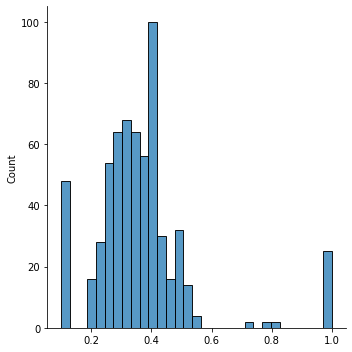

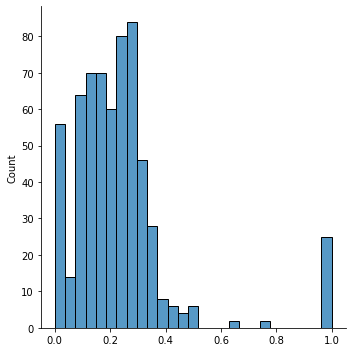

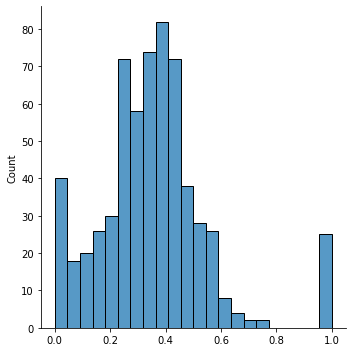

In [166]:
import seaborn as sns

# построить график распределения схожести
 
sns.displot(RDKit_Similarity)
sns.displot(morgan_Similarity)
sns.displot(MACCS_Similarity)
